In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import scipy.io as sio
from pathlib import Path
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt


import sys
sys.path.append("../src")
from conversion_mat_to_py import mat2dict, pretty_dict, matobj2dict, dict2ntuple
from sources_cv2 import defineStartEnd, count_frames
from save_datas import save_data
from data_conversions import acc_to_angle


In [2]:
def defineRowingPhases(video_path, n_frames, frame_no=0):
    cap = cv2.VideoCapture(video_path)
    pose_frame = [0,0,0,0,0]
    moment = 0
    if(cap.isOpened() == False):
        print("Error opening video stream or file")
        print(video_path)
        sys.exit(-1)
    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        ret_val, img = cap.read()
        if ret_val:
            img = cv2.resize(img, (960, 540)) 
            cv2.imshow('Video Analysis', img)
        arg = cv2.waitKey(1)
        if arg == 27:
            break  # esc to quit
        elif arg == 13: # pressed enter
            pose_frame[moment] = frame_no
            moment = (moment+1)%5
            print(pose_frame)
        elif arg == 100:
            frame_no = (frame_no+1)%n_frames
        elif arg == 97:
            frame_no = (frame_no-1)%n_frames
    cap.release()
    cv2.destroyAllWindows()
    return pose_frame

In [3]:
def mean_filter(data, number_of_points, step=1):
    mean_feature = []
    for i in range(0, number_of_points):
        mean_feature.append(np.mean(data[0: i+1]))
    if number_of_points > 1:
        for i in range(0, len(data) - number_of_points, step):
            mean_feature.append(
                np.mean(data[i: number_of_points + i]))
    else:
        return data
    return np.array(mean_feature)

In [4]:
def name_data(voluntary, key):
    
    data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

    if key == 'S1_Synched':
        name = 'S1'
        sincro = '_Synched'
    
    elif key == 'S2_Synched':
        name = 'S2'
        sincro = '_Synched'

    else:
        name = key
        sincro = ''

    arquivo = name + '_Subject_' + voluntary + sincro + '_Sit_and_Stand.csv'
    
    return arquivo, name, sincro

# -> Escolher voluntário e chave

* Voluntário => 1 até 90
* Chaves => 'S1_Synched', 'S2_Synched', 'I1', 'I2', 'S1', 'S2'

In [5]:
''' Alterar o número do voluntário e a chave da repetição'''

voluntary = 1
key = 'S1_Synched'

voluntary = str(voluntary)


In [6]:
''' Voluntário Referência'''

ref_voluntary = 1 
ref_key = 'S2_Synched'

ref_voluntary = str(ref_voluntary)

In [7]:
archive, name, sincro = name_data(voluntary, key)
ref_archive, ref_name, ref_sincro = name_data(ref_voluntary, ref_key)
video_path = '/Users/User/OneDrive/TCC/MoVi/Videos/'
data_path = '/Users/User/OneDrive/TCC/ema_motion_analysis_imu/data/'

In [8]:
data = pd.read_csv(data_path + archive, sep = ';')
ref_data = pd.read_csv(data_path + ref_archive, sep = ';')

### Separando os dados de aceleração para cada sensor

'Hip' 'RightUpLeg' 'LeftUpLeg' 'Head' 'Neck' 'Spine3' 'Spine2' 'Spine1' 'Spine'

In [9]:
Hip = data.iloc[:,0:3].values
RightUpLeg = data.iloc[:,3:6].values
LeftUpLeg = data.iloc[:,6:9].values
Head = data.iloc[:,9:12].values
Neck = data.iloc[:,12:15].values
Spine3 = data.iloc[:,15:18].values
Spine2 = data.iloc[:,18:21].values
Spine1 = data.iloc[:,21:24].values
Spine = data.iloc[:,24:27].values

In [10]:
angle_rad_hip, angle_hip = acc_to_angle(Hip)
angle_rad_right_up_leg, angle_right_up_leg = acc_to_angle(RightUpLeg)
angle_rad_left_up_leg, angle_left_up_leg = acc_to_angle(LeftUpLeg)
angle_rad_head, angle_head = acc_to_angle(Head)
angle_rad_neck, angle_neck = acc_to_angle(Neck)
angle_rad_spine3, angle_spine3 = acc_to_angle(Spine3)
angle_rad_spine2, angle_spine2 = acc_to_angle(Spine2)
angle_rad_spine1, angle_spine1 = acc_to_angle(Spine1)
angle_rad_spine, angle_spine = acc_to_angle(Spine)

In [11]:
# Definindo a frequência de amostragem
freq_amostragem = 120


''' Alterar janela do filtro '''
window_size_s = 0.1


# Definindo o número de amostras a serem filtrados
number_of_points = int(round(freq_amostragem * window_size_s))

# definindo o tempo em segundos das amostras
t_right_up_leg = np.linspace(0, len(angle_right_up_leg) / freq_amostragem, len(angle_right_up_leg))
t_left_up_leg = np.linspace(0, len(angle_left_up_leg) / freq_amostragem, len(angle_left_up_leg))
t_hip = np.linspace(0, len(angle_hip) / freq_amostragem, len(angle_hip))
t_head = np.linspace(0, len(angle_head) / freq_amostragem, len(angle_head))
t_neck = np.linspace(0, len(angle_neck) / freq_amostragem, len(angle_neck))
t_spine3 = np.linspace(0, len(angle_spine3) / freq_amostragem, len(angle_spine3))
t_spine2 = np.linspace(0, len(angle_spine2) / freq_amostragem, len(angle_spine2))
t_spine1 = np.linspace(0, len(angle_spine1) / freq_amostragem, len(angle_spine1))
t_spine = np.linspace(0, len(angle_spine) / freq_amostragem, len(angle_spine))

In [12]:
angle_right_up_leg_mean = mean_filter(angle_right_up_leg, number_of_points, step=1)
angle_left_up_leg_mean = mean_filter(angle_left_up_leg, number_of_points, step=1)
angle_hip_mean = mean_filter(angle_hip, number_of_points, step=1)
angle_head_mean = mean_filter(angle_head, number_of_points, step=1)
angle_neck_mean = mean_filter(angle_neck, number_of_points, step=1)
angle_spine3_mean = mean_filter(angle_spine3, number_of_points, step=1)
angle_spine2_mean = mean_filter(angle_spine2, number_of_points, step=1)
angle_spine1_mean = mean_filter(angle_spine1, number_of_points, step=1)
angle_spine_mean = mean_filter(angle_spine, number_of_points, step=1)

### Comparação dos dados filtrados e não filtrados

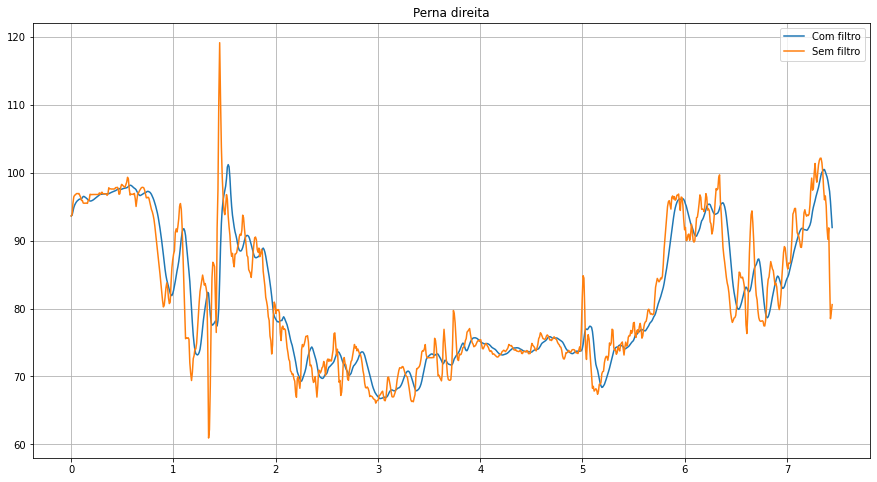

In [13]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_right_up_leg, angle_right_up_leg_mean, label = 'Com filtro')
plt.plot(t_right_up_leg, angle_right_up_leg, label = 'Sem filtro')
plt.legend()
plt.title('Perna direita')
plt.grid()
plt.show()

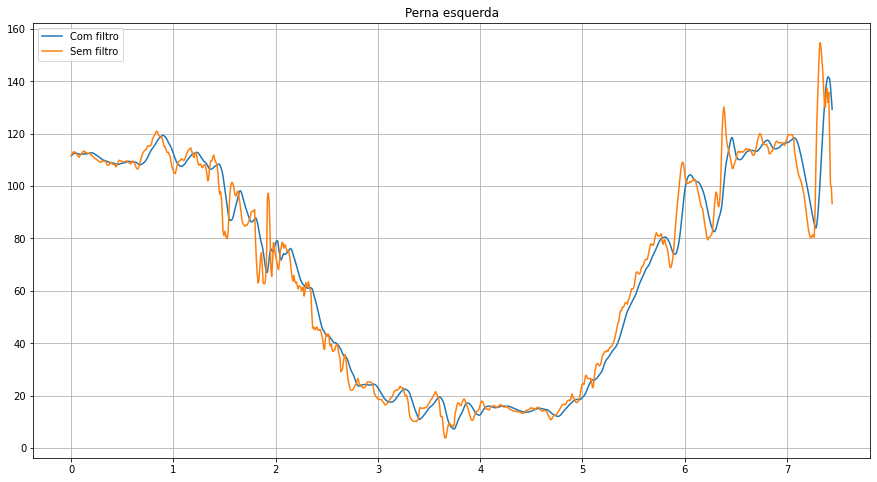

In [14]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_left_up_leg, angle_left_up_leg_mean, label = 'Com filtro')
plt.plot(t_left_up_leg, angle_left_up_leg, label = 'Sem filtro')
plt.legend()
plt.title('Perna esquerda')
plt.grid()
plt.show()

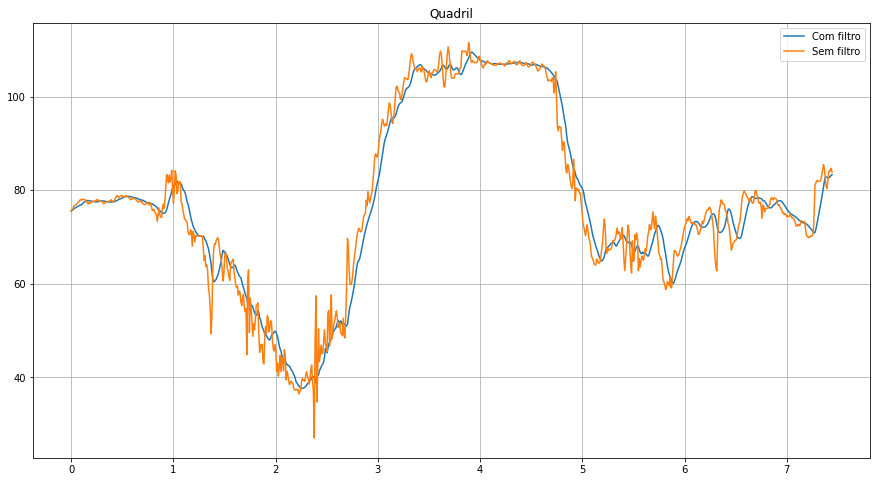

In [15]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_hip, angle_hip_mean, label = 'Com filtro')
plt.plot(t_hip, angle_hip, label = 'Sem filtro')
plt.legend()
plt.title('Quadril')
plt.grid()
plt.show()

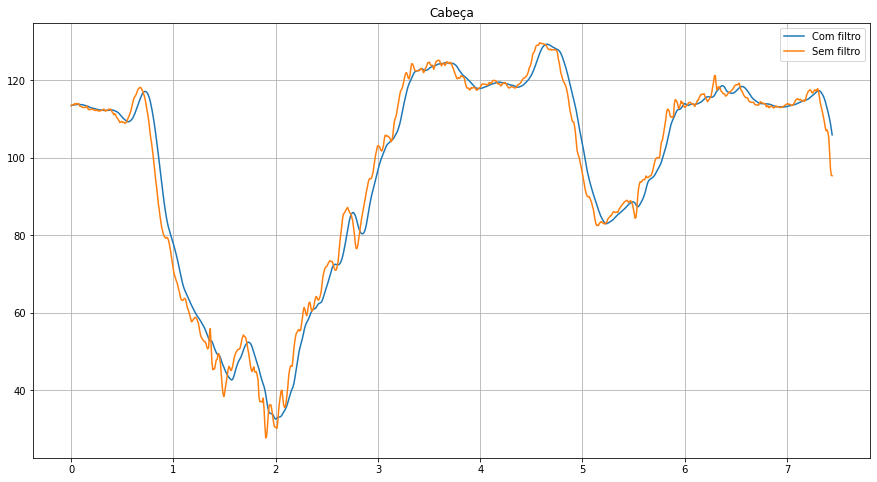

In [16]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_head, angle_head_mean, label = 'Com filtro')
plt.plot(t_head, angle_head, label = 'Sem filtro')
plt.legend()
plt.title('Cabeça')
plt.grid()
plt.show()

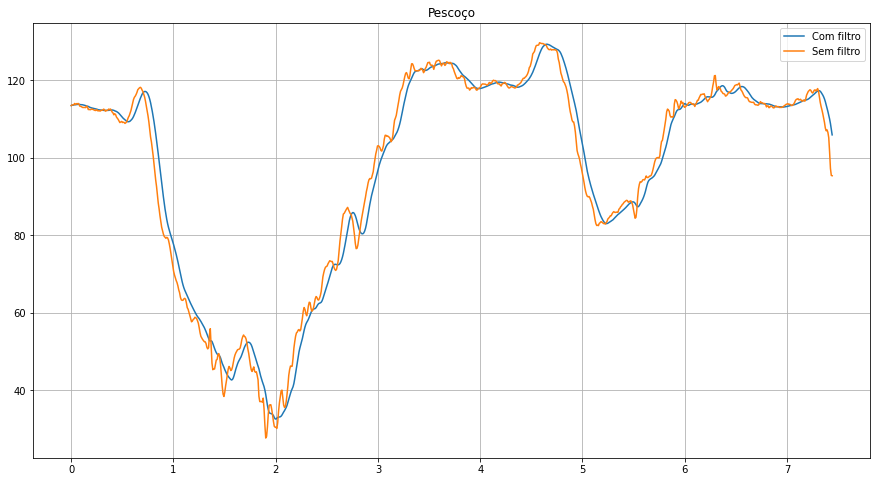

In [17]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_neck, angle_neck_mean, label = 'Com filtro')
plt.plot(t_neck, angle_neck, label = 'Sem filtro')
plt.legend()
plt.title('Pescoço')
plt.grid()
plt.show()

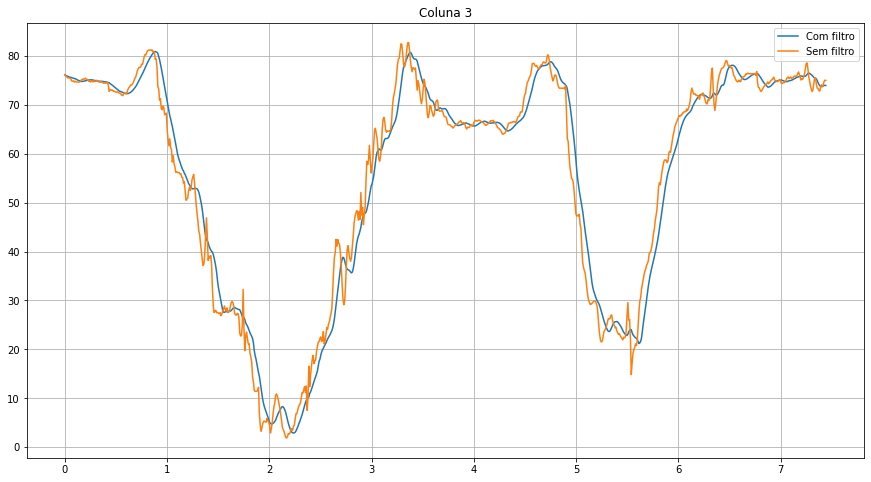

In [18]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine3, angle_spine3_mean, label = 'Com filtro')
plt.plot(t_spine3, angle_spine3, label = 'Sem filtro')
plt.legend()
plt.title('Coluna 3')
plt.grid()
plt.show()

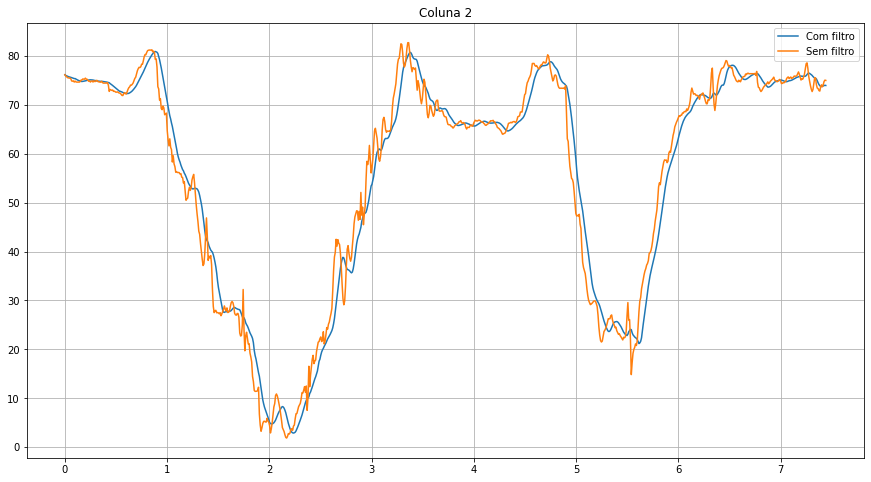

In [19]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine2, angle_spine2_mean, label = 'Com filtro')
plt.plot(t_spine2, angle_spine2, label = 'Sem filtro')
plt.legend()
plt.title('Coluna 2')
plt.grid()
plt.show()

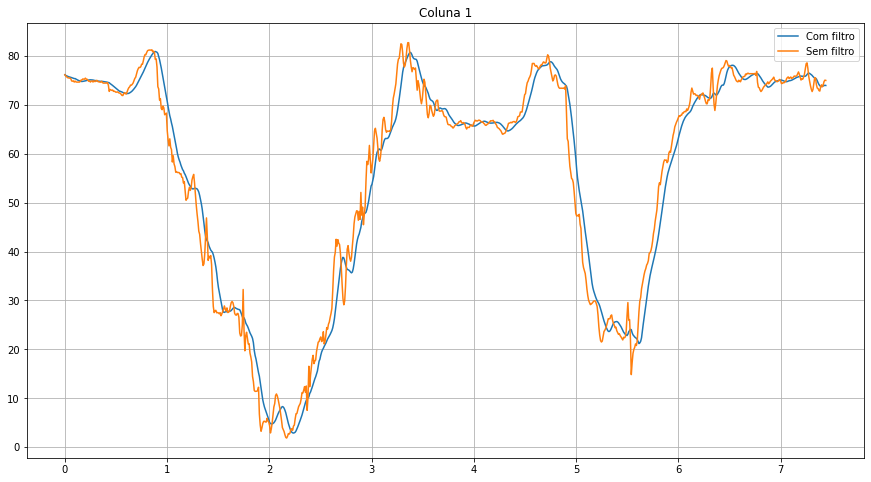

In [20]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine1, angle_spine1_mean, label = 'Com filtro')
plt.plot(t_spine1, angle_spine1, label = 'Sem filtro')
plt.legend()
plt.title('Coluna 1')
plt.grid()
plt.show()

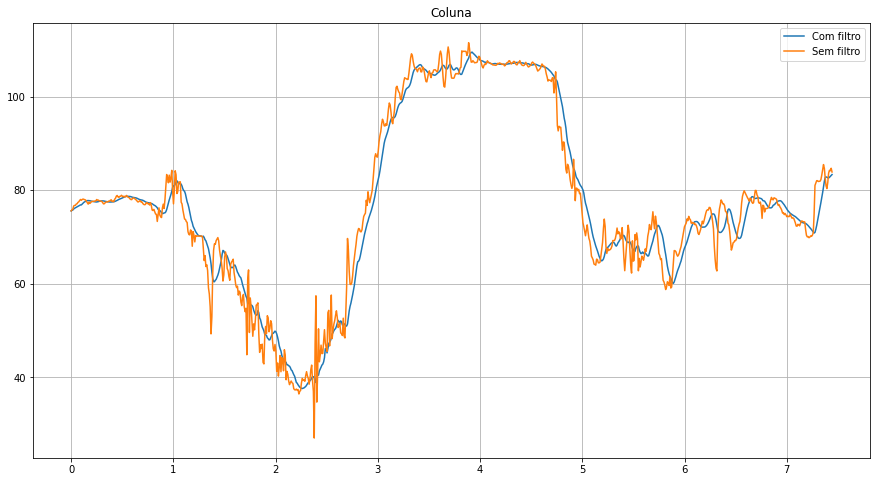

In [21]:
plt.figure(figsize=[15,8])
plt.subplot(111)
plt.plot(t_spine, angle_spine_mean, label = 'Com filtro')
plt.plot(t_spine, angle_spine, label = 'Sem filtro')
plt.legend()
plt.title('Coluna')
plt.grid()
plt.show()